In [1]:
import os
os.chdir('/home/jovyan/work')
print(os.getcwd())

/home/jovyan/work


In [2]:
import argparse
import json
import pathlib
import contextlib
import random
import networkx as nx
import numpy as np
# from qiskit import QuantumCircuitav
from qiskit.converters import circuit_to_dagdependency

from compilation import is_qasm_file, manual_copy_dag, remove_node, update_sequence
from Cycles import GraphCreator, MemoryZone, get_idx_from_idc


In [3]:
# JSONファイルの読み込み
config_file = 'algorithms_heuristic/full_register_access_06.json'
with pathlib.Path(config_file).open("r") as f:
    config = json.load(f)

# 変数の設定
arch = config["arch"]
max_timesteps = config["max_timesteps"]
num_ion_chains = config["num_ion_chains"]
filename = config["qu_alg"]

print(f"Architecture: {arch}, Max Timesteps: {max_timesteps}, Number of Ion Chains: {num_ion_chains}")


Architecture: [3, 3, 1, 1], Max Timesteps: 50, Number of Ion Chains: 6


In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from more_itertools import distinct_combinations, pairwise

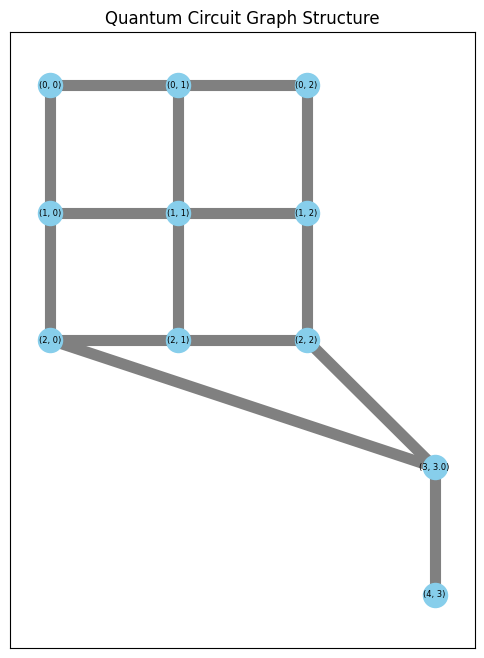

Number of traps: 12


In [5]:
m, n, v, h = arch
graph_creator = GraphCreator(m, n, v, h)
graph = graph_creator.get_graph()

# pos をカスタム設定
pos = {(x, y): (y, -x) for i, (x, y) in enumerate(list(graph.nodes()))}
# グラフの描画
plt.figure(figsize=(max(pos.keys())[1] * 2, max(pos.keys())[0] * 2))
nx.draw_networkx(
    graph,
    pos=pos,
    with_labels=True,
    node_size=300,
    node_color="skyblue",
    width=8,
    edge_color="gray",
    font_size=6,
)
plt.title("Quantum Circuit Graph Structure")
plt.show()

# トラップ数の確認
n_of_traps = len([trap for trap in graph.edges() if graph.get_edge_data(trap[0], trap[1])["edge_type"] == "trap"])
print(f"Number of traps: {n_of_traps}")

In [6]:
# for trap in graph.edges():
#     print(f"Trap {trap}: {graph.get_edge_data(trap[0], trap[1])}")

for node in graph.nodes(data=True):
    print(f"Node {node[0]}: {node[1]}")

Node (0, 0): {'node_type': 'junction_node', 'color': 'g'}
Node (0, 1): {'node_type': 'junction_node', 'color': 'g'}
Node (0, 2): {'node_type': 'junction_node', 'color': 'g'}
Node (1, 0): {'node_type': 'junction_node', 'color': 'g'}
Node (1, 1): {'node_type': 'junction_node', 'color': 'g'}
Node (1, 2): {'node_type': 'junction_node', 'color': 'g'}
Node (2, 0): {'node_type': 'junction_node', 'color': 'g'}
Node (2, 1): {'node_type': 'junction_node', 'color': 'g'}
Node (2, 2): {'node_type': 'junction_node', 'color': 'g'}
Node (3, 3.0): {'node_type': 'processing_zone_node', 'color': 'r'}
Node (4, 3): {'node_type': 'parking_node', 'color': 'r'}


In [7]:
from run_heuristic import create_starting_config
ion_chains, number_of_registers = create_starting_config(num_ion_chains, graph, n_of_traps, seed=42)

# 初期配置の可視化
for ion, pos in ion_chains.items():
    print(f"Ion {ion} starts at edge {pos}")

Ion 0 starts at edge ((2, 0), (2, 1))
Ion 1 starts at edge ((0, 0), (0, 1))
Ion 2 starts at edge ((0, 0), (1, 0))
Ion 3 starts at edge ((0, 2), (1, 2))
Ion 4 starts at edge ((0, 1), (0, 2))
Ion 5 starts at edge ((2, 1), (2, 2))


{0: 3, 1: 5, 2: 5, 3: 3, 4: 4, 5: 2}
OPENQASM 2.0;

Initial sequence: [(5,), (0,), (3,), (4,), (1,), (2,)]
Flat sequence: [5, 0, 3, 4, 1, 2]
DAG dependency: <qiskit.dagcircuit.dagdependency.DAGDependency object at 0xffff6b496d00>

Timestep: 0, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [5, 0, 4, 1]
path_to_pz [((2, 2), (3, 3.0))]


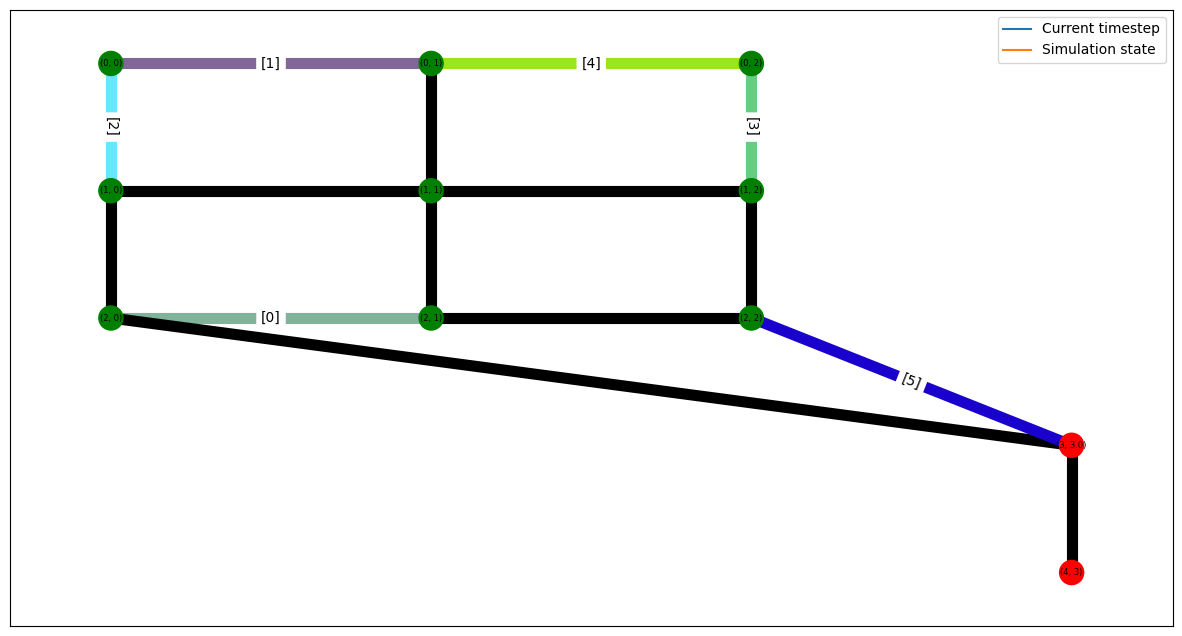

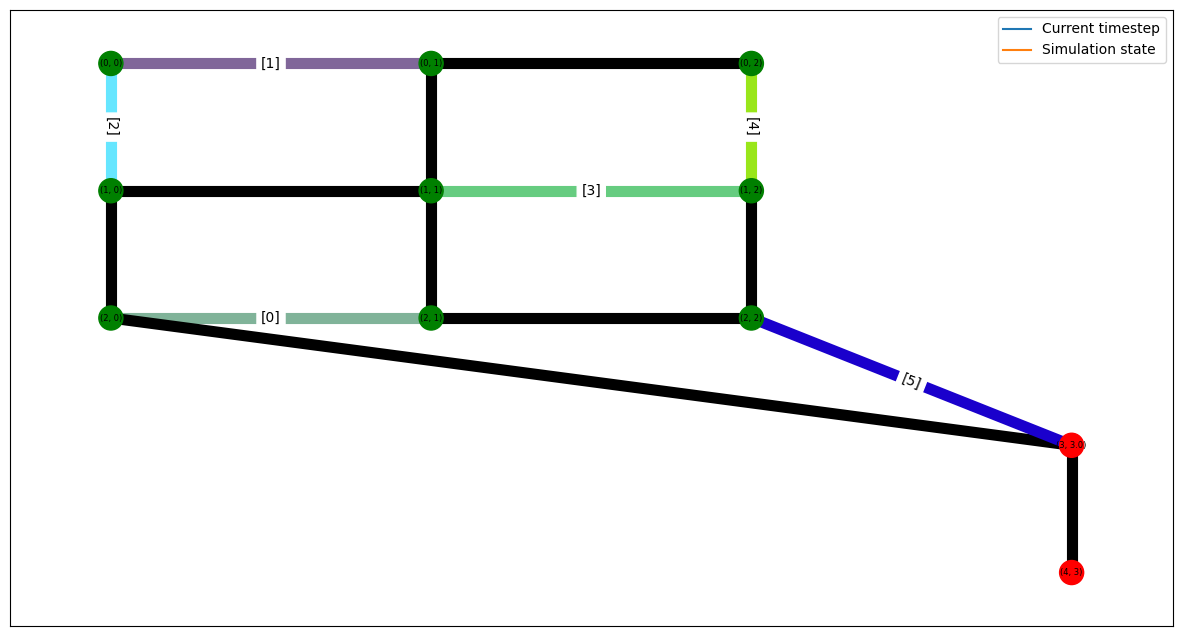


Timestep: 1, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [5, 0, 1]
path_to_pz [((2, 2), (3, 3.0))]


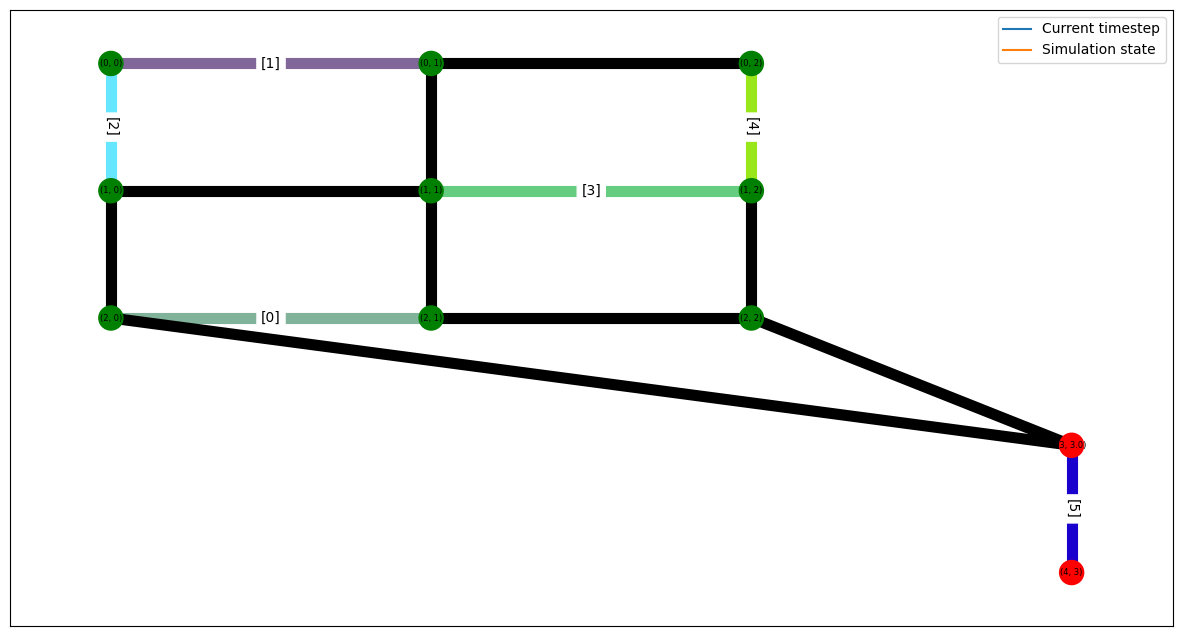

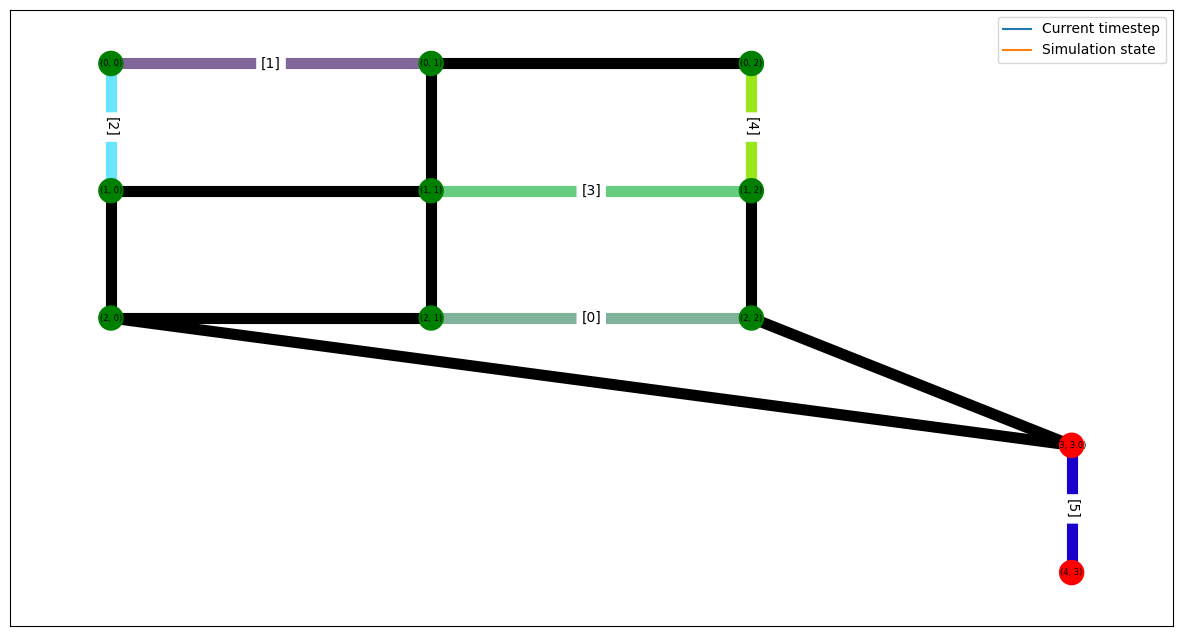

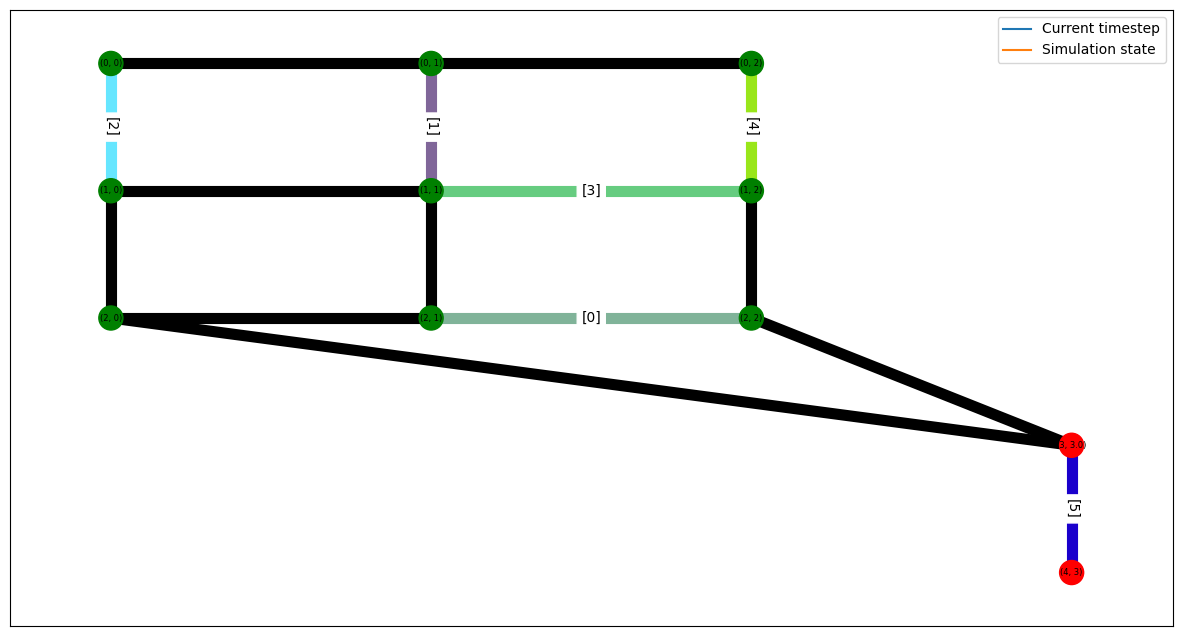


time step: 1, gate (5,) is executed,

Timestep: 2, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [0, 3, 1, 2]
path_to_pz [((2, 2), (3, 3.0))]


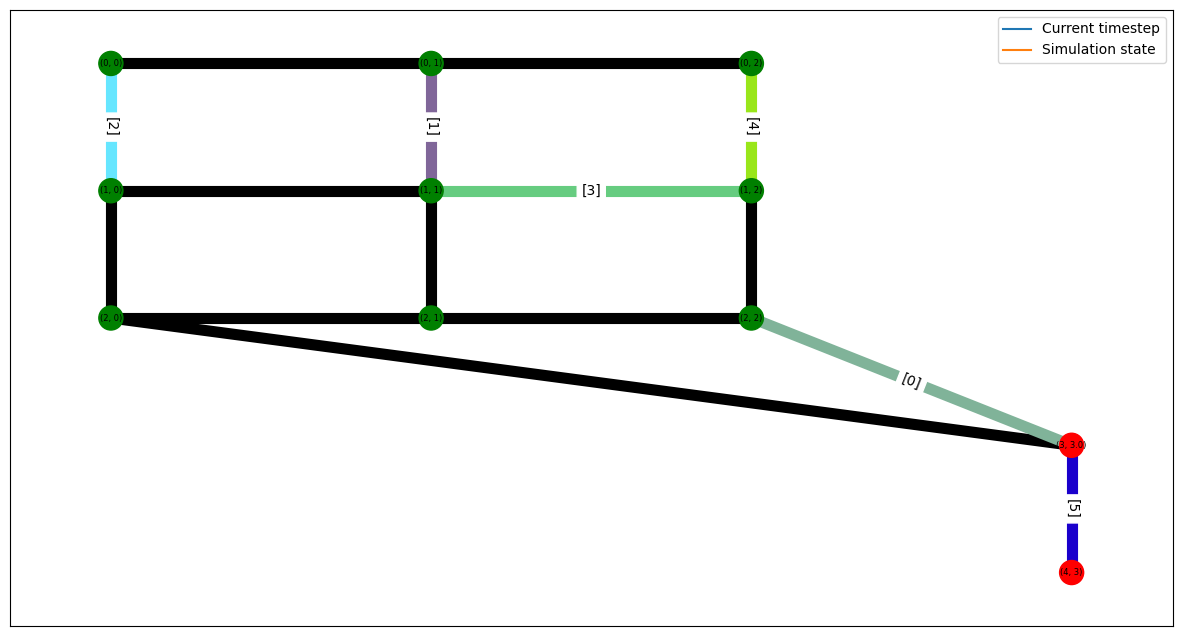

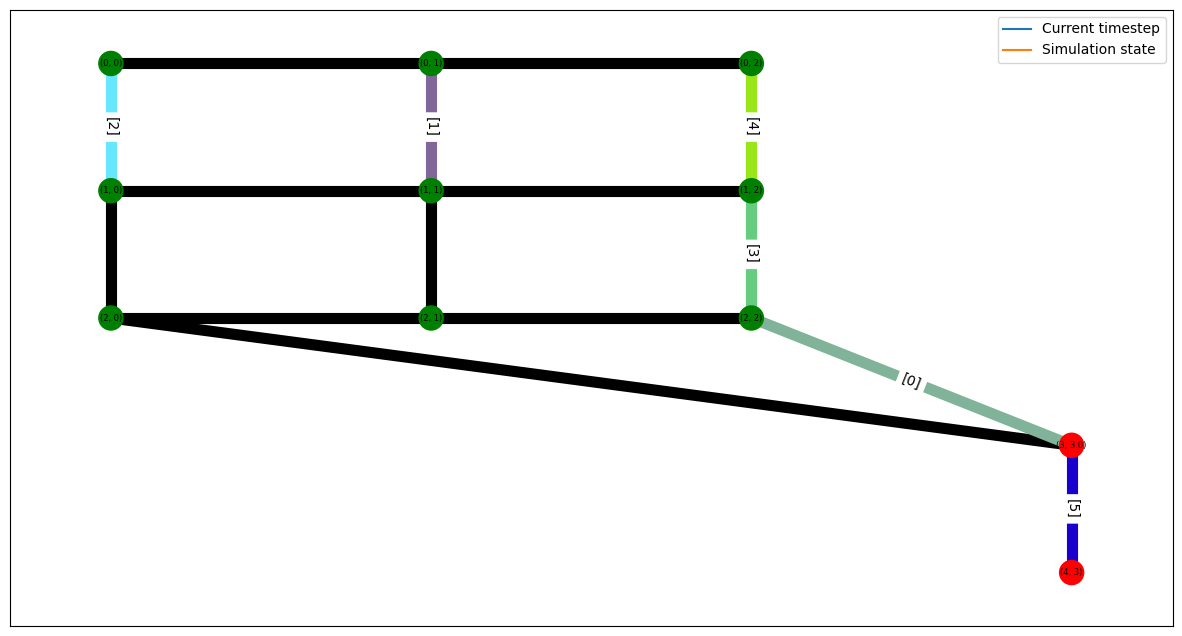

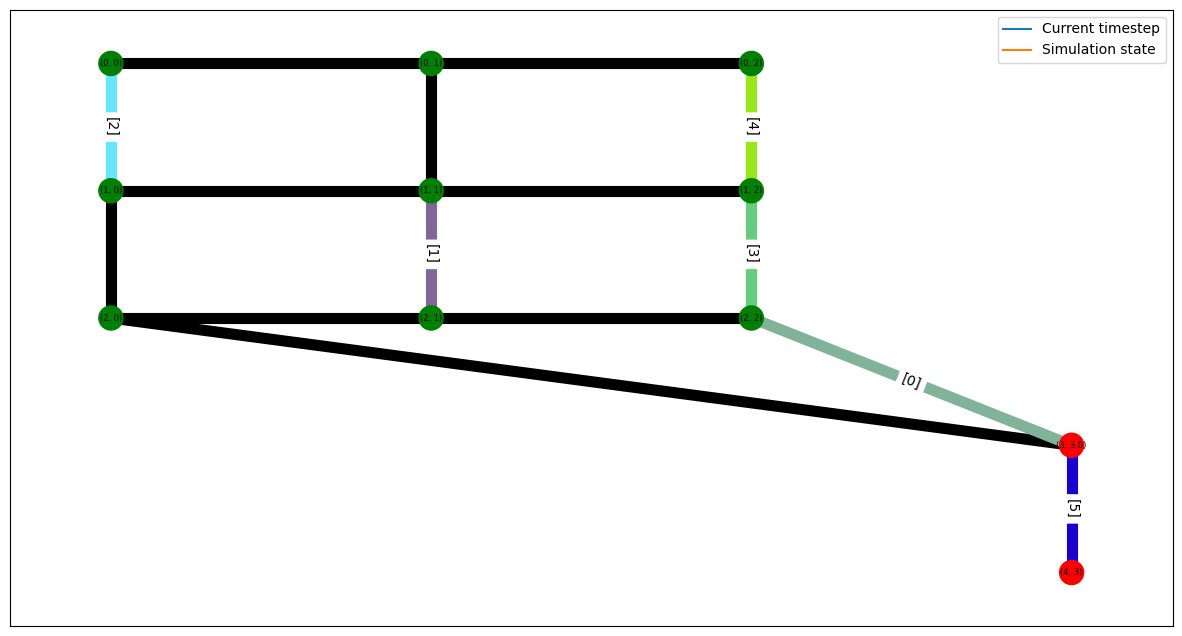

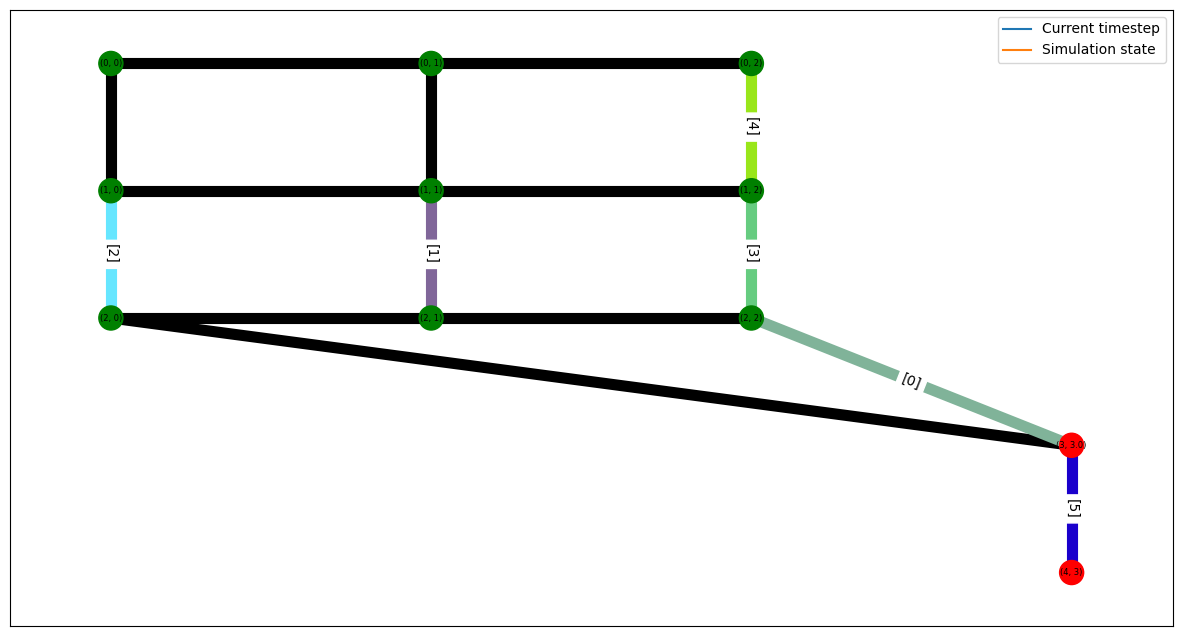


Timestep: 3, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [0, 3, 4, 2]
path_to_pz [((2, 2), (3, 3.0))]


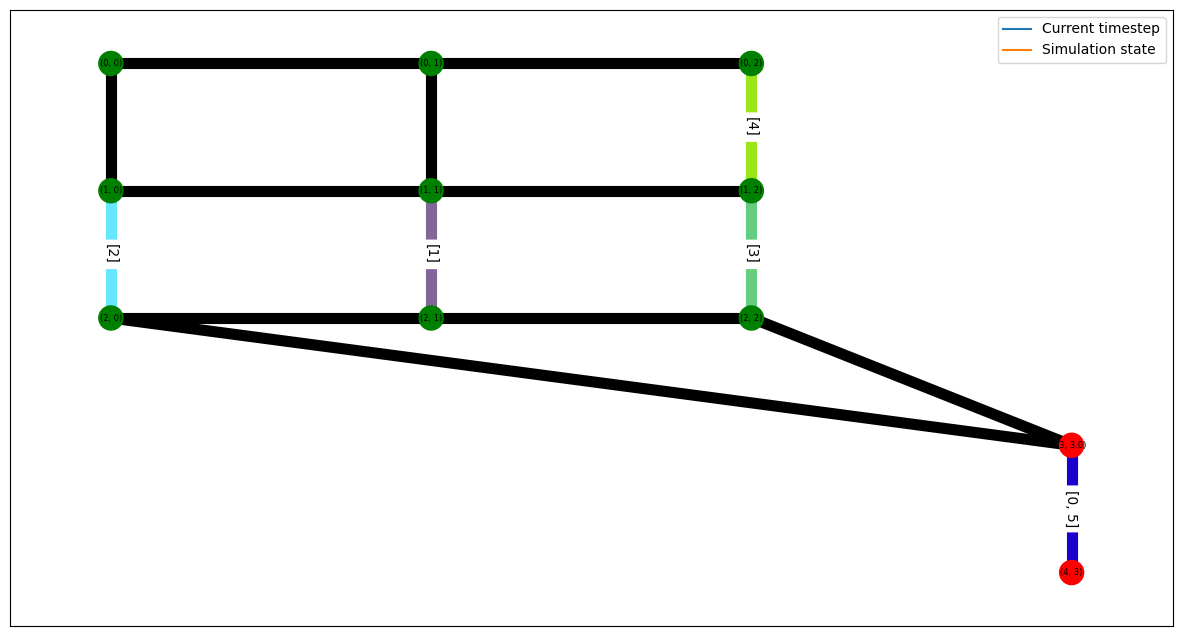

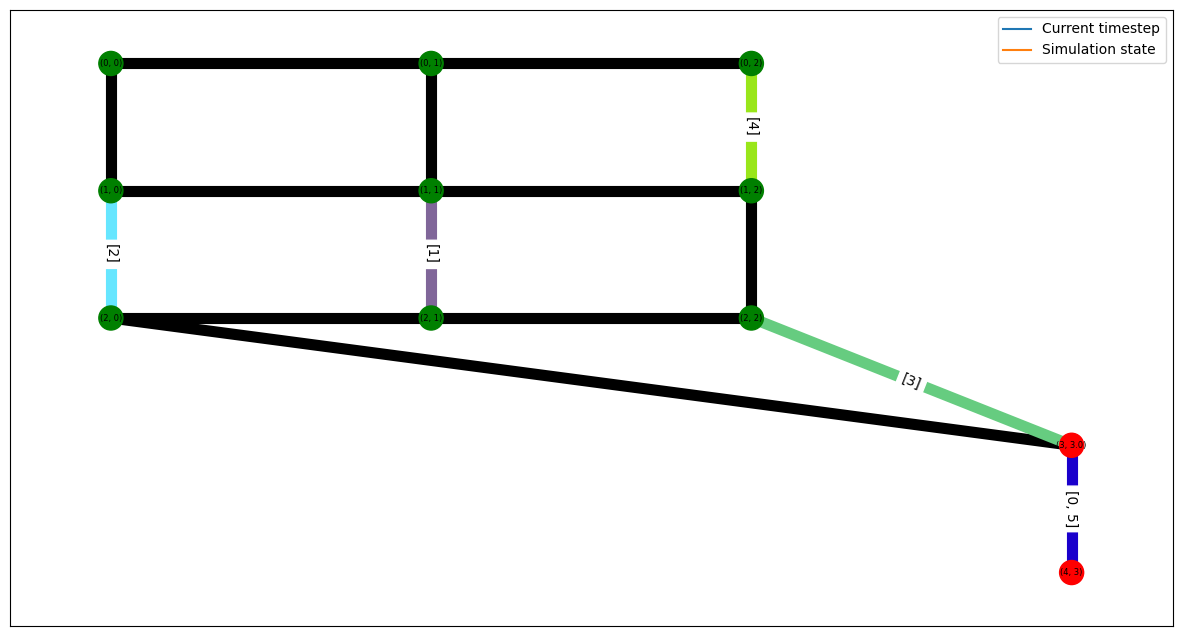

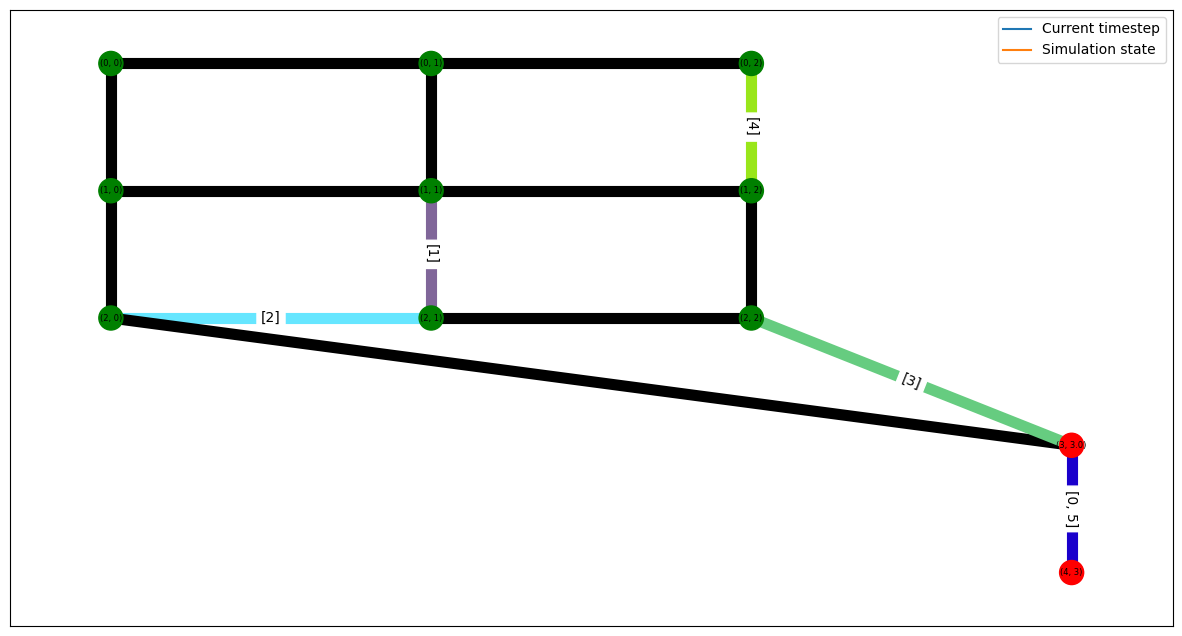


time step: 3, gate (0,) is executed,

Timestep: 4, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [3, 1]
path_to_pz [((2, 2), (3, 3.0))]


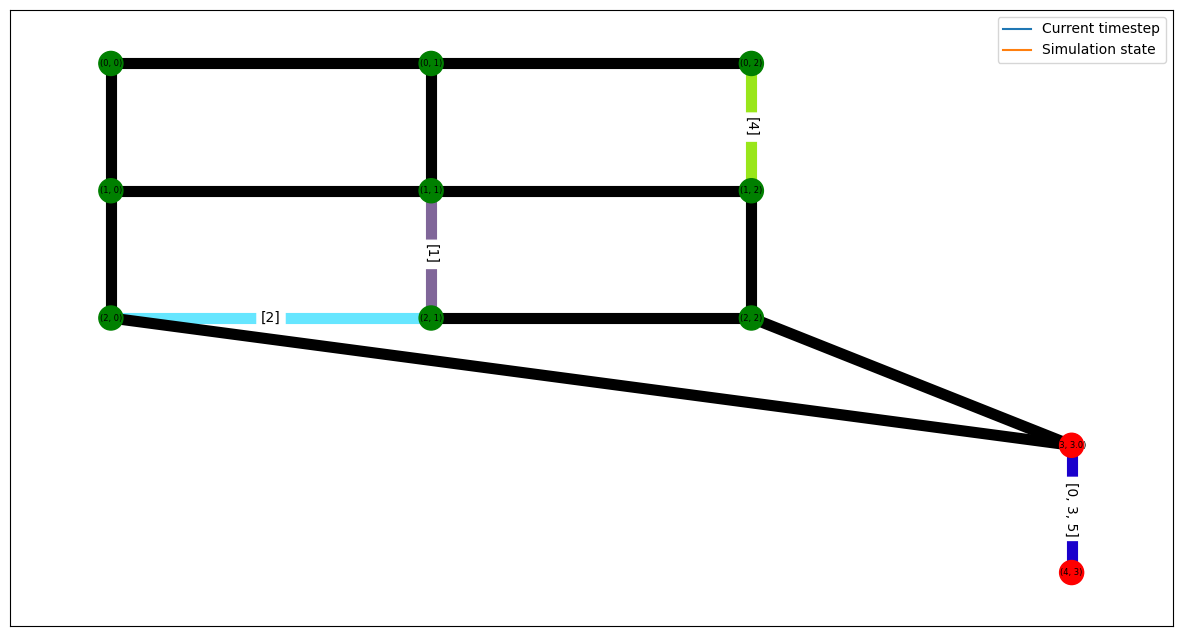

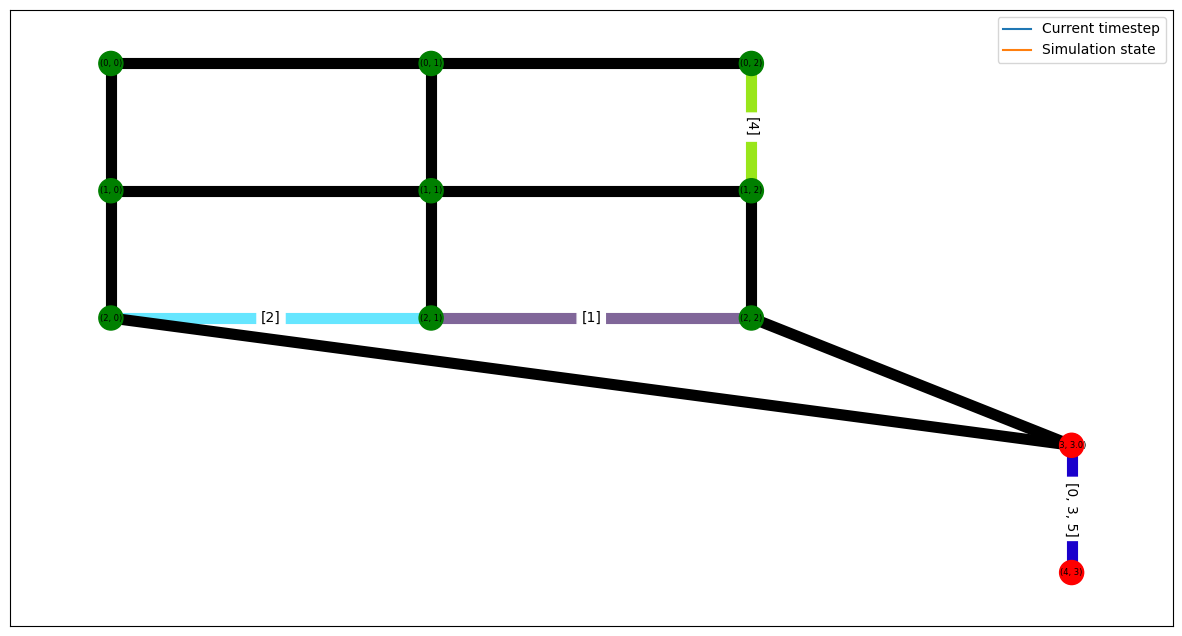


time step: 4, gate (3,) is executed,

Timestep: 5, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [1, 2]
path_to_pz [((2, 2), (3, 3.0))]


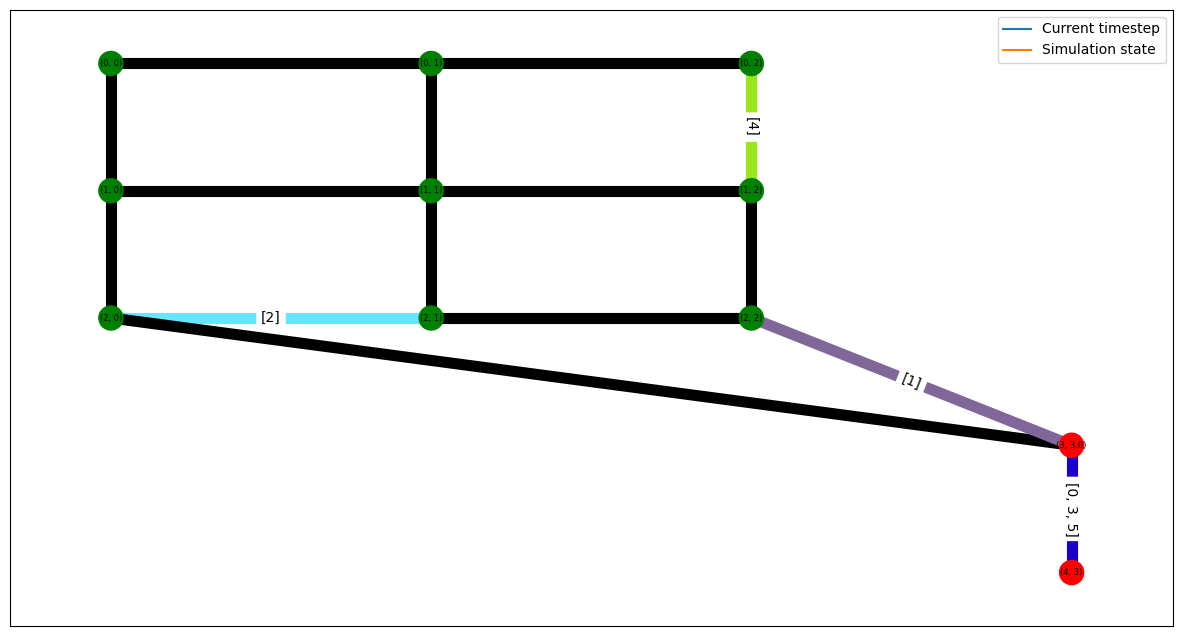


Timestep: 6, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [1, 2]
path_to_pz [((2, 2), (3, 3.0))]


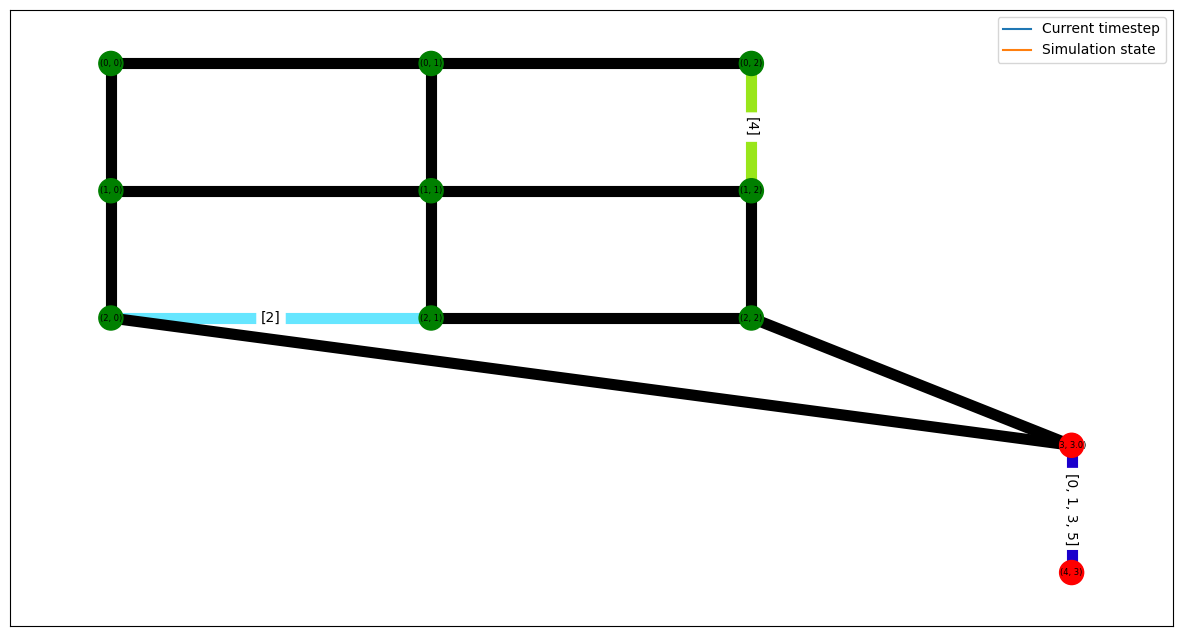

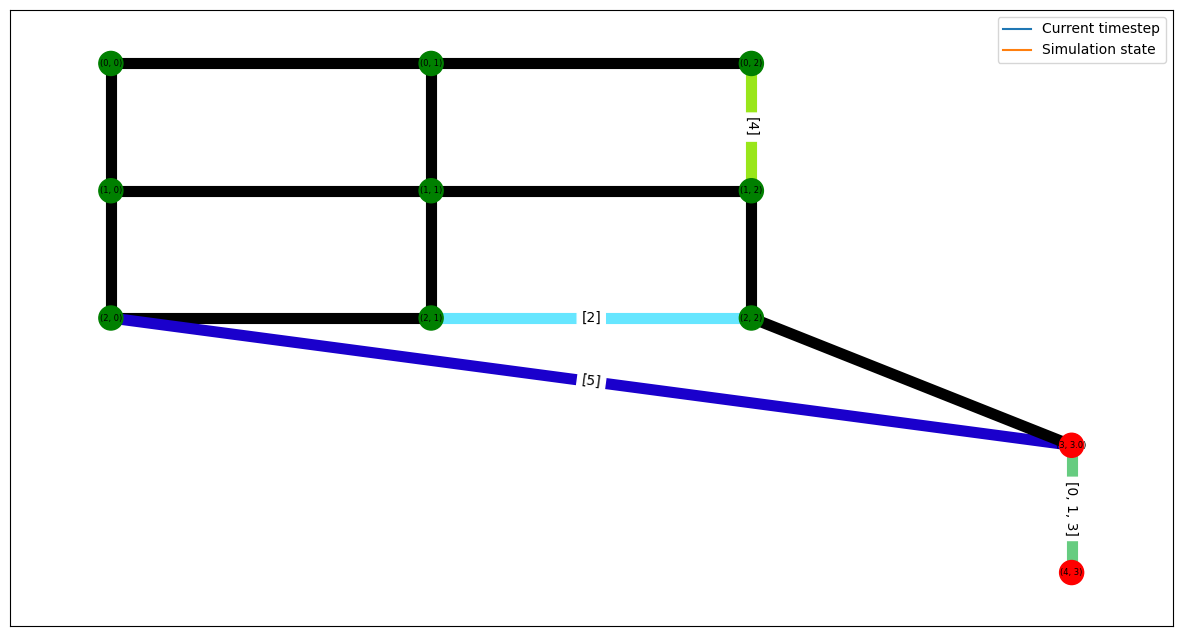


time step: 6, gate (1,) is executed,

Timestep: 7, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [5, 2, 4]
path_to_pz [((2, 2), (3, 3.0))]


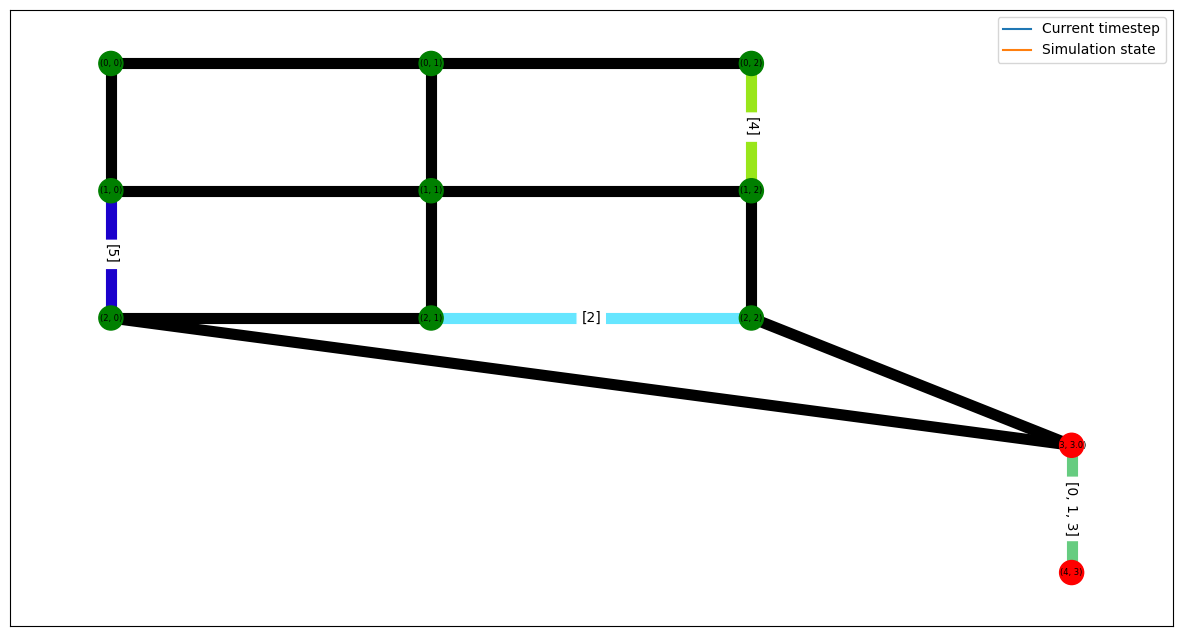

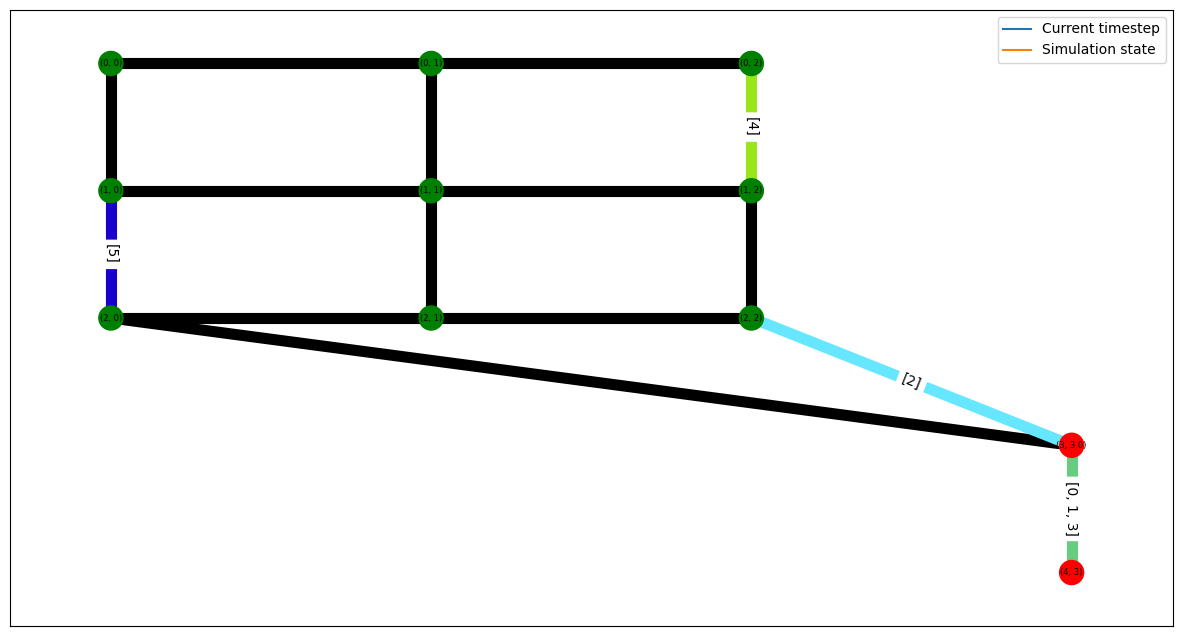

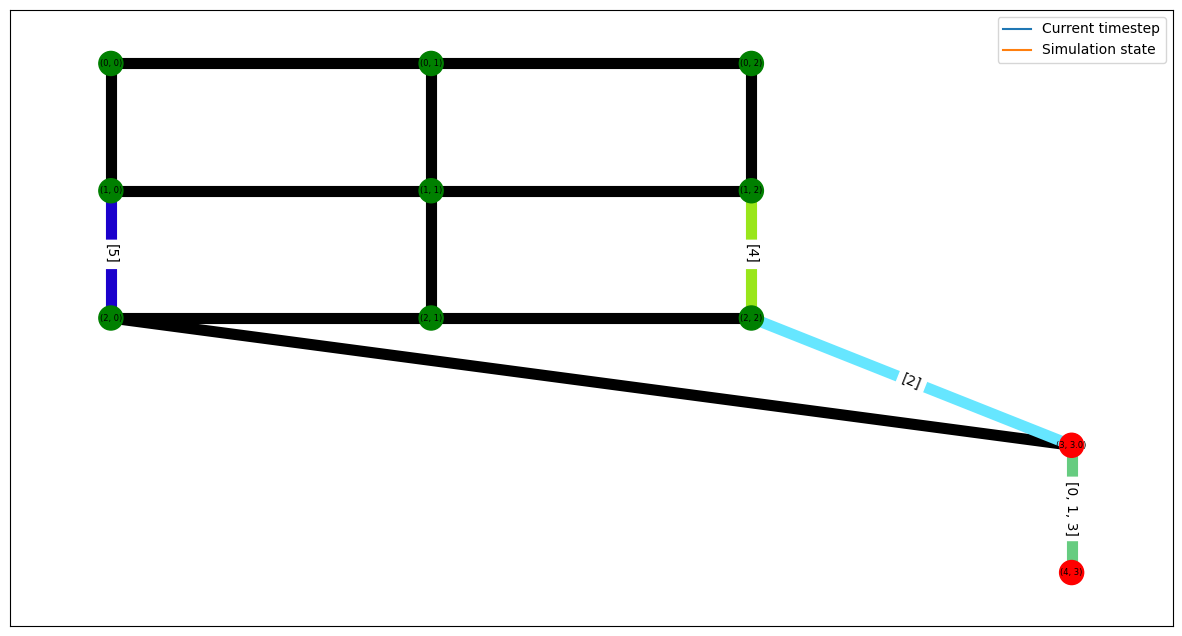


Timestep: 8, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [2, 4]
path_to_pz [((2, 2), (3, 3.0))]


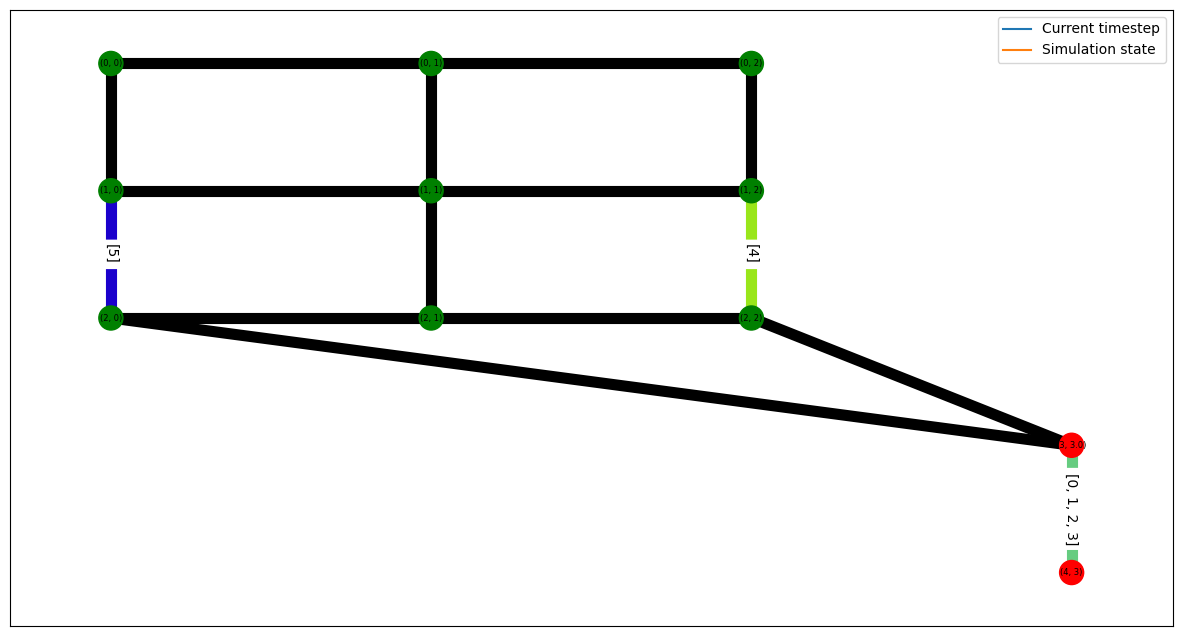

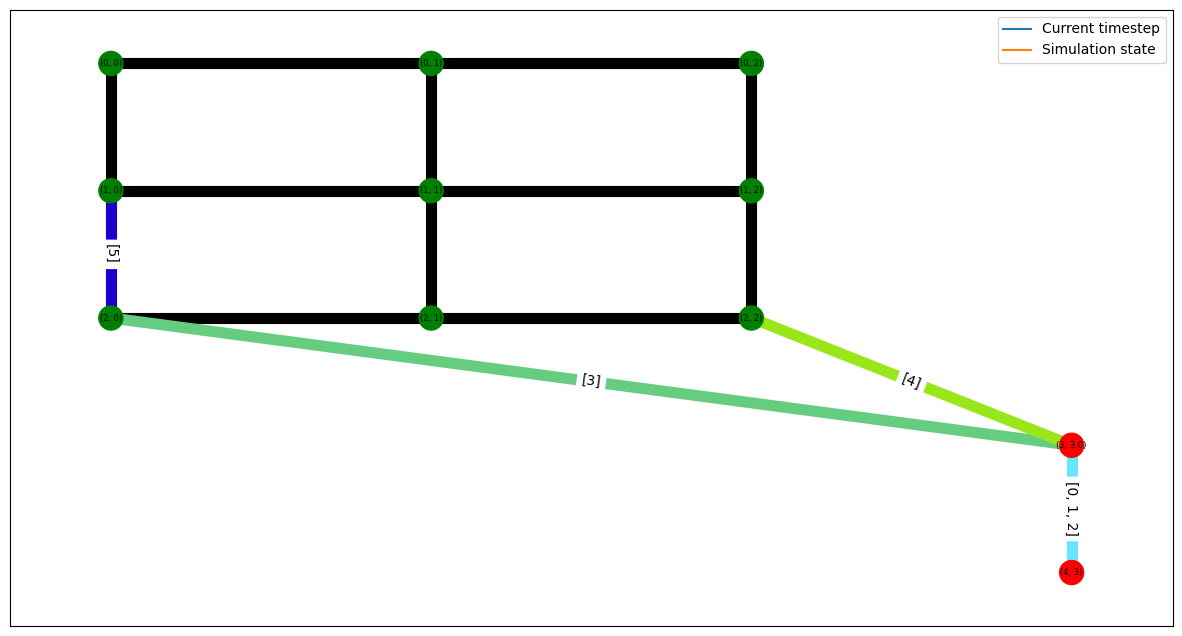


time step: 8, gate (2,) is executed,

Timestep: 9, state: [((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 0), (2, 1)), ((2, 0), (3, 3.0)), ((2, 1), (2, 2)), ((2, 2), (3, 3.0)), ((3, 3.0), (4, 3))]
move_list [3, 4]
path_to_pz [((2, 2), (3, 3.0))]


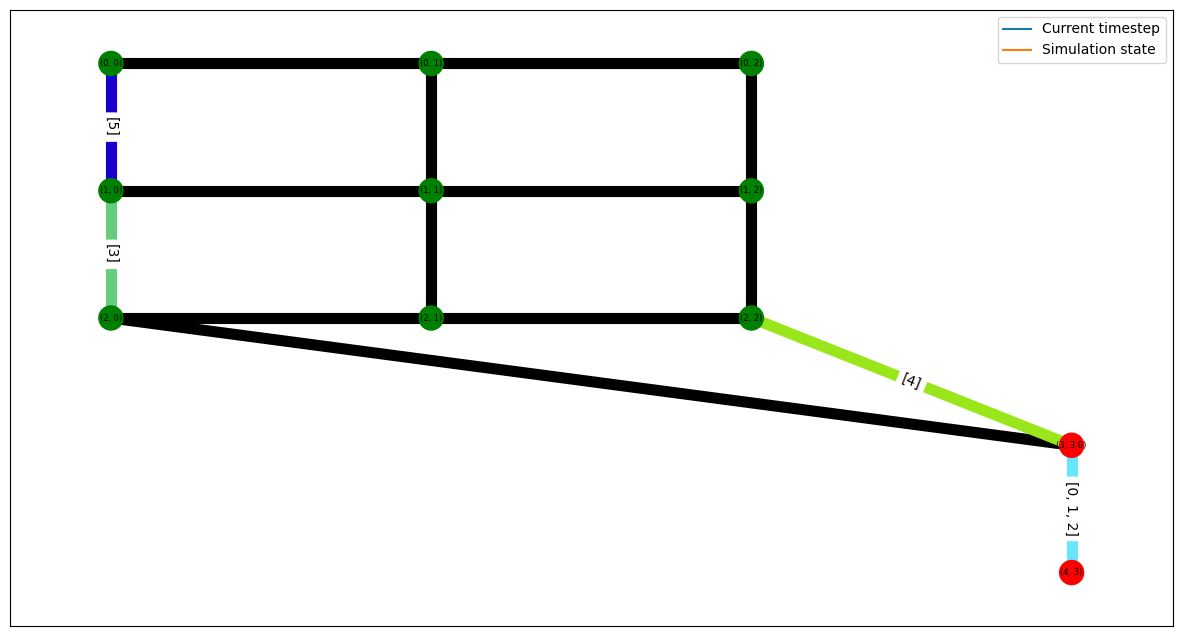

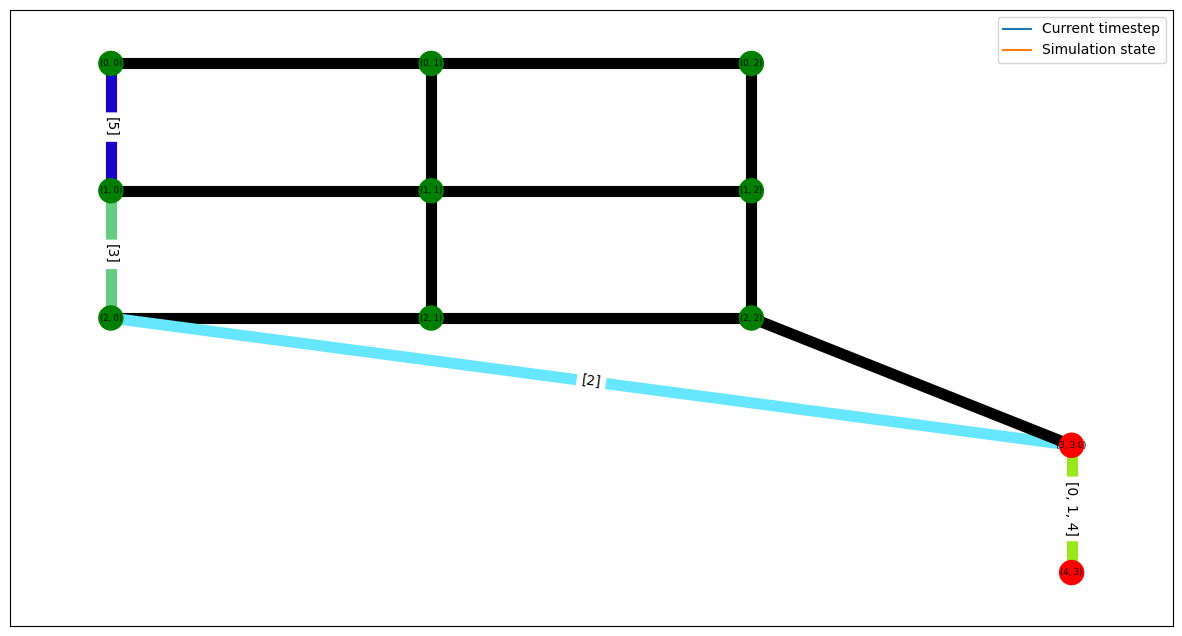


time step: 9, gate (4,) is executed,

Full Sequence executed in 9 time steps


In [8]:
from run_heuristic import create_initial_sequence, run_simulation
# MemoryZoneのインスタンス作成
iontrap = MemoryZone(
    m, n, v, h, ion_chains, max_timesteps, 3,
    time_2qubit_gate=3, time_1qubit_gate=1
)

iontrap.update_distance_map()
distance_map = iontrap.distance_map
print(distance_map)

# 初期シーケンスの生成
seq, flat_seq, dag_dep, next_node = create_initial_sequence(distance_map, filename)
print(f"Initial sequence: {seq}")
print(f"Flat sequence: {flat_seq}")
print(f"DAG dependency: {dag_dep}")


# シミュレーションの実行
run_simulation(iontrap, max_timesteps, seq, flat_seq, dag_dep, next_node, max_length=10, time_1qubit_gate=1, time_2qubit_gate=3)